In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
from tqdm import tqdm

api = wandb.Api()
ENT = "TomFrederik"
PROJ = "MT-ToyTask-Dreamer"
JOB_ID = "9748422" #NOTE <-- change this for new runs

def gen_run_id_list(job_id):
    my_list = []
    for setting_num in range(21):
        for seed_num in range(3):
            my_list.append(f"setting_{setting_num}_seed_{seed_num}_job_{job_id}")
    return my_list

def fetch_last_loss(run_id: str, loss_name: str = "tuning_loss") -> float:
    run = api.run(f"{ENT}/{PROJ}/{run_id}")
    return run.history(keys=[f'Validation/{loss_name}']).iloc[-1][f'Validation/{loss_name}']


def fetch_loss_list_per_setting(job_id, loss_name: str = "tuning_loss"):
    out_dict = dict()
    for setting_num in tqdm(range(21)):
        loss_list = []
        for seed_num in range(3):
            run_id = f"setting_{setting_num}_seed_{seed_num}_job_{job_id}"
            loss = fetch_last_loss(run_id, loss_name)
            loss_list.append(loss)
        out_dict[setting_num] = loss_list
    return out_dict

def compute_mean_std_per_setting(loss_dict):
    out_dict = dict()
    for key, val in loss_dict.items():
        mean = np.mean(val)
        std = np.std(val, ddof=1)
        out_dict[key] = (mean, std)
    return out_dict

In [2]:
# run id lists per setting
no_05 = [2, 4, 6]
yes_05 = [0, 1, 3, 5]
no_075 = [9, 11, 13]
yes_075 = [7, 8, 10, 12]
no_1 = [16, 18, 20]
yes_1 = [14, 15, 17, 19]

In [10]:
loss_name = "value_prefix_loss"
# loss_name = "tuning_loss"
mean_std_per_setting = compute_mean_std_per_setting(fetch_loss_list_per_setting(JOB_ID, loss_name))

100%|██████████| 21/21 [00:27<00:00,  1.32s/it]


In [4]:
print(mean_std_per_setting)

{0: (0.36729346712430316, 0.006033576336437555), 1: (0.5185596545537313, 0.082722378419505), 2: (0.38258079687754315, 0.006145668795238942), 3: (0.6215701301892599, 0.09174566020978342), 4: (0.3712140719095866, 0.0012302609145506379), 5: (0.933683713277181, 0.21346552112075745), 6: (0.33309858043988544, 0.006987232578049059), 7: (0.3853563567002614, 0.015751259894848192), 8: (0.6529984871546427, 0.10097466042253153), 9: (0.41566288471221924, 0.02665589192664763), 10: (1.0421603322029114, 0.32870206644917155), 11: (0.4128321011861165, 0.029877951087361514), 12: (1.6311863660812378, 0.22978452964482746), 13: (0.4164981047312419, 0.011426657753053232), 14: (0.4468764166037242, 0.009888454343078357), 15: (0.9221760034561157, 0.38450514951486936), 16: (0.46262309948603314, 0.02343965114771252), 17: (1.6368075013160706, 0.8047102819895224), 18: (0.47471897800763446, 0.019501891193333405), 19: (1.9812979698181152, 1.1699734726089817), 20: (0.5076951881249746, 0.014992751460289815)}


In [12]:
test_only_true_view_05 = [mean_std_per_setting[key] for key in yes_05]
test_only_true_view_075 = [mean_std_per_setting[key] for key in yes_075]
test_only_true_view_1 = [mean_std_per_setting[key] for key in yes_1]

test_only_false_view_05 = [mean_std_per_setting[key] for key in no_05]
test_only_false_view_075 = [mean_std_per_setting[key] for key in no_075]
test_only_false_view_1 = [mean_std_per_setting[key] for key in no_1]

In [13]:
print(test_only_true_view_05)

[(0.0001226300846610684, 5.679708644833366e-05), (0.010118752407530943, 0.0032839100989098396), (0.026737229898571968, 0.00971939864140833), (0.07686237618327141, 0.023968527584109462)]


In [14]:
xticks_yes = np.array([0, 0.1, 0.2, 0.5])
xticks_no = np.array([0.1, 0.2, 0.5])
plot_kwargs = dict(width=0.025, capsize=4)

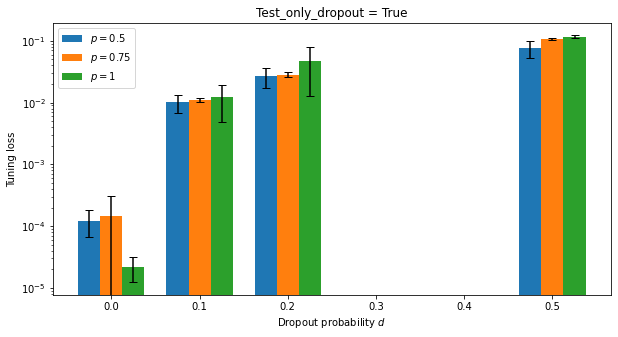

In [17]:
# eval for test_only true
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(xticks_yes-0.025, [x[0] for x in test_only_true_view_05], yerr=[x[1] for x in test_only_true_view_05], label=r"$p=0.5$", **plot_kwargs)
ax.bar(xticks_yes, [x[0] for x in test_only_true_view_075], yerr=[x[1] for x in test_only_true_view_075], label=r"$p=0.75$", **plot_kwargs)
ax.bar(xticks_yes+0.025, [x[0] for x in test_only_true_view_1], yerr=[x[1] for x in test_only_true_view_1], label=r"$p=1$", **plot_kwargs)
plt.title("Test_only_dropout = True")
plt.yscale("log")
plt.xlabel(r"Dropout probability $d$")
plt.ylabel("Tuning loss")
plt.legend()

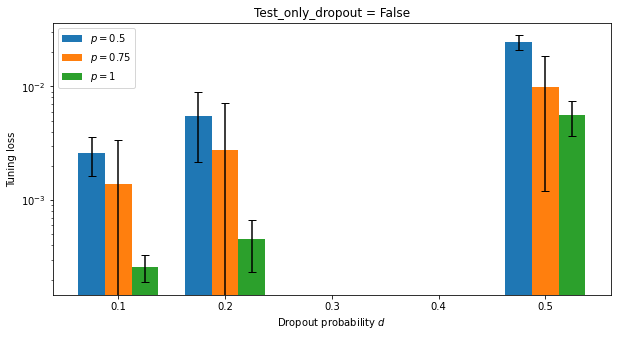

In [18]:
# eval for test_only false
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(xticks_no-0.025, [x[0] for x in test_only_false_view_05], yerr=[x[1] for x in test_only_false_view_05], label=r"$p=0.5$", **plot_kwargs)
ax.bar(xticks_no, [x[0] for x in test_only_false_view_075], yerr=[x[1] for x in test_only_false_view_075], label=r"$p=0.75$", **plot_kwargs)
ax.bar(xticks_no+0.025, [x[0] for x in test_only_false_view_1], yerr=[x[1] for x in test_only_false_view_1], label=r"$p=1$", **plot_kwargs)
plt.title("Test_only_dropout = False")
plt.yscale("log")
plt.xlabel(r"Dropout probability $d$")
plt.ylabel("Tuning loss")
plt.legend()